파이썬 버전 : 3.10.13 (main, Apr  3 2024, 17:08:15) [GCC 9.4.0]
pandas 버전 : 2.2.1
numpy 버전 : 1.26.4
Epoch 1/20, Train Loss: 2.5545, Train Accuracy: 0.6152, Val Loss: 0.5210, Val Accuracy: 0.8185
Epoch 2/20, Train Loss: 0.6235, Train Accuracy: 0.7811, Val Loss: 0.4334, Val Accuracy: 0.8383
Epoch 3/20, Train Loss: 0.5302, Train Accuracy: 0.8064, Val Loss: 0.3797, Val Accuracy: 0.8600
Epoch 4/20, Train Loss: 0.4803, Train Accuracy: 0.8267, Val Loss: 0.3521, Val Accuracy: 0.8700
Epoch 5/20, Train Loss: 0.4579, Train Accuracy: 0.8270, Val Loss: 0.3364, Val Accuracy: 0.8721
Epoch 6/20, Train Loss: 0.4224, Train Accuracy: 0.8455, Val Loss: 0.3176, Val Accuracy: 0.8779
Epoch 7/20, Train Loss: 0.4104, Train Accuracy: 0.8459, Val Loss: 0.2956, Val Accuracy: 0.8849
Epoch 8/20, Train Loss: 0.3943, Train Accuracy: 0.8506, Val Loss: 0.2887, Val Accuracy: 0.8884
Epoch 9/20, Train Loss: 0.3853, Train Accuracy: 0.8596, Val Loss: 0.2825, Val Accuracy: 0.8907
Epoch 10/20, Train Loss: 0.3727, Train Accuracy: 0

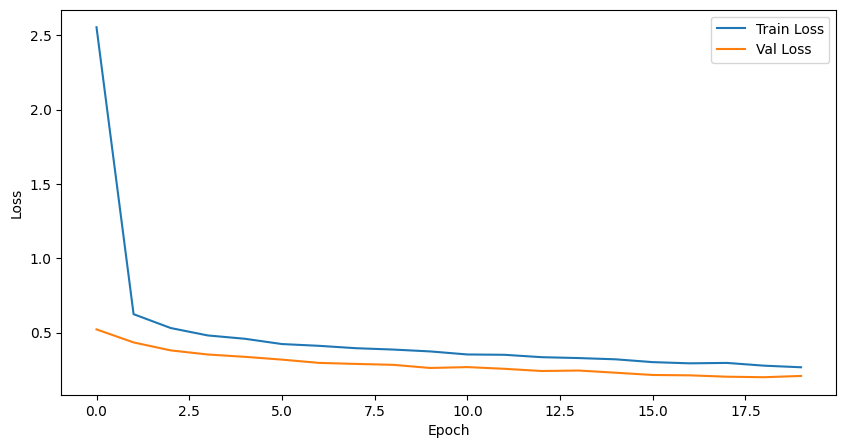

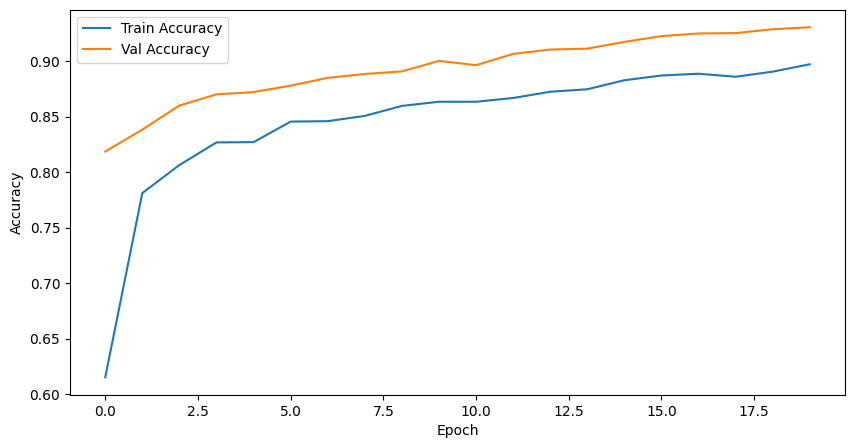

Test Accuracy: 0.9305


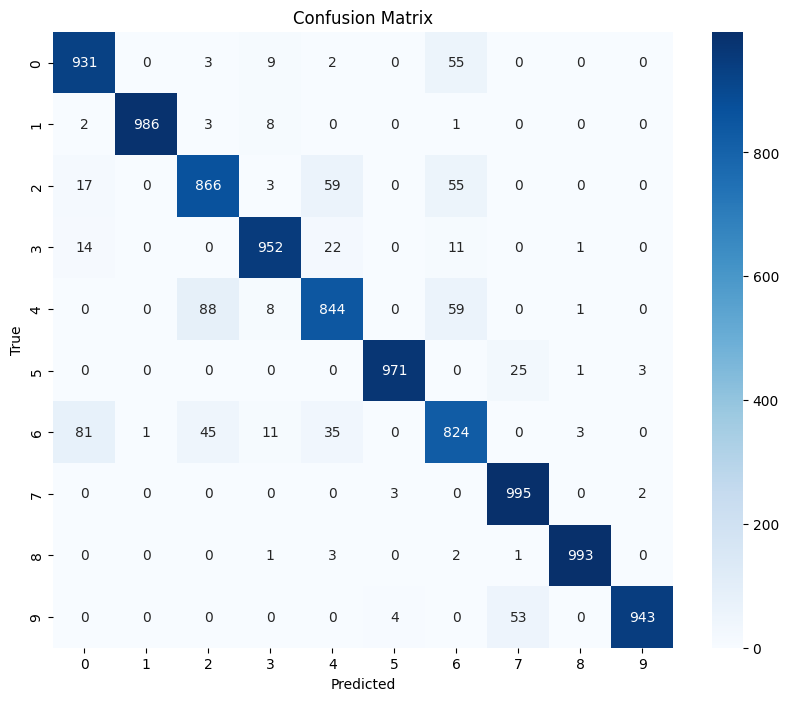

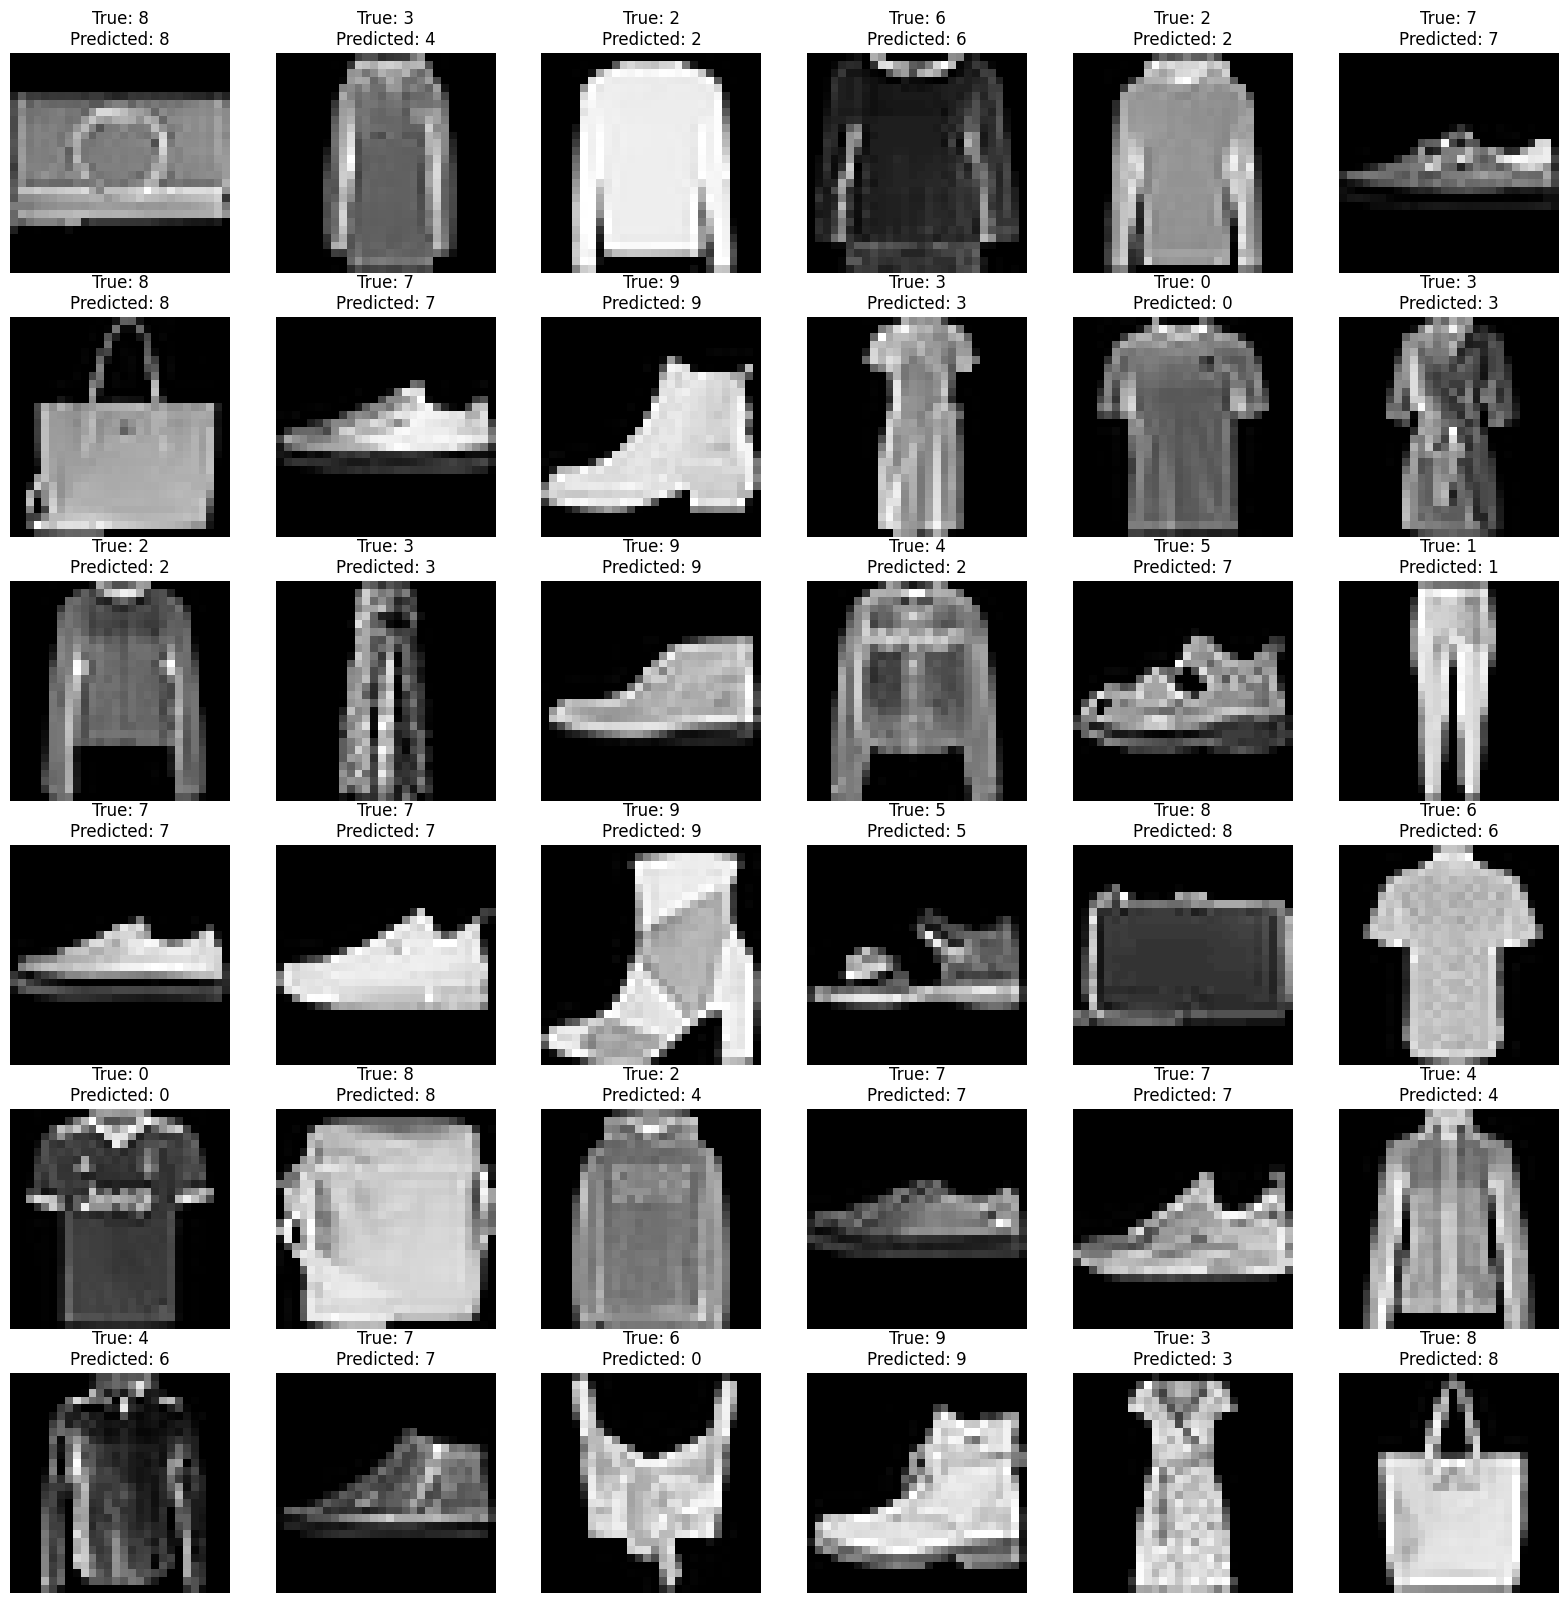

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import numpy as np
import struct
import sys

print(f"파이썬 버전 : {sys.version}")
print(f"pandas 버전 : {pd.__version__}")
print(f"numpy 버전 : {np.__version__}")

# MNIST 데이터를 파일에서 읽어오는 함수 정의
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
        return images

# MNIST 레이블을 파일에서 읽어오는 함수 정의
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# MNIST 데이터 로드
train_images = load_mnist_images("t10k-images-idx3-ubyte")
train_labels = load_mnist_labels("t10k-labels-idx1-ubyte")

# 데이터를 텐서로 변환하여 PyTorch의 DataLoader로 사용하기 위해 준비
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # (num_images, 1, 28, 28)
train_labels = torch.tensor(train_labels, dtype=torch.long)  # (num_images,)

# 데이터를 학습용과 테스트용으로 분할
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# PyTorch의 DataLoader로 변환
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 검증 데이터 로드
val_images = load_mnist_images("t10k-images-idx3-ubyte")
val_labels = load_mnist_labels("t10k-labels-idx1-ubyte")
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)  # (num_images, 1, 28, 28)
val_labels = torch.tensor(val_labels, dtype=torch.long)  # (num_images,)
val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 첫 번째 컨볼루션 레이어: 입력 채널 1, 출력 채널 32, 커널 크기 3x3, 패딩 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # 두 번째 컨볼루션 레이어: 입력 채널 32, 출력 채널 64, 커널 크기 3x3, 패딩 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 최대 풀링 레이어: 2x2 크기의 풀링
        self.pool = nn.MaxPool2d(2, 2)
        # 드롭아웃 레이어: 25%의 드롭아웃 비율
        self.dropout1 = nn.Dropout(0.25)
        # 완전 연결 레이어: 입력 크기 64x7x7, 출력 크기 128
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # 드롭아웃 레이어: 50%의 드롭아웃 비율
        self.dropout2 = nn.Dropout(0.5)
        # 출력 레이어: 입력 크기 128, 출력 크기 10 (클래스 수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 첫 번째 컨볼루션 레이어를 통과한 후 최대 풀링
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # 두 번째 컨볼루션 레이어를 통과한 후 최대 풀링
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # 드롭아웃 적용
        x = self.dropout1(x)
        # 텐서 펼치기
        x = torch.flatten(x, 1)
        # 첫 번째 완전 연결 레이어를 통과한 후 활성화 함수 적용
        x = nn.functional.relu(self.fc1(x))
        # 두 번째 드롭아웃 레이어를 통과한 후 출력 레이어에 전달
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# 모델 초기화
model = SimpleCNN()

# 손실 함수와 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 함수 정의
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # 학습 데이터로더를 통해 미니배치 단위로 데이터를 가져와 모델을 학습
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 검증 데이터셋에 대한 손실과 정확도 계산
        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 에포크마다 학습과 검증 결과 출력
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# 모델 훈련
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs=20)

# 손실과 정확도 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 평가
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
    correct_test = 0
    total_test = 0

    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")

# 혼동 행렬 생성
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# 혼동 행렬 출력
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 잘못 분류된 이미지 출력
plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(len(y_true), 36, replace=False)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(val_dataset[idx][0].squeeze(), cmap='gray')
    plt.title(f'True: {y_true[idx]}\nPredicted: {y_pred[idx]}')
    plt.axis('off')
plt.show()

# 테스트 데이터에 대한 예측
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()  # 모델을 평가 모드로 설정